Dataset yang digunakan: https://www.kaggle.com/datasets/szrlee/stock-time-series-20050101-to-20171231/data

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from keras.optimizers import SGD
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/content/drive/MyDrive/proyek machine learning/proyek time series prediction(LSTM)/GOOGL_2006-01-01_to_2018-01-01.csv')
df

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL
1,2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL
2,2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL
3,2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL
4,2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL
...,...,...,...,...,...,...,...
3014,2017-12-22,1070.00,1071.72,1067.64,1068.86,889446,GOOGL
3015,2017-12-26,1068.64,1068.86,1058.64,1065.85,918767,GOOGL
3016,2017-12-27,1066.60,1068.27,1058.38,1060.20,1116203,GOOGL
3017,2017-12-28,1062.25,1064.84,1053.38,1055.95,994249,GOOGL


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3019 non-null   object 
 1   Open    3019 non-null   float64
 2   High    3019 non-null   float64
 3   Low     3019 non-null   float64
 4   Close   3019 non-null   float64
 5   Volume  3019 non-null   int64  
 6   Name    3019 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 165.2+ KB


In [4]:
df.duplicated().sum()

0

Text(0.5, 1.0, 'Close Price of GOOGLE')

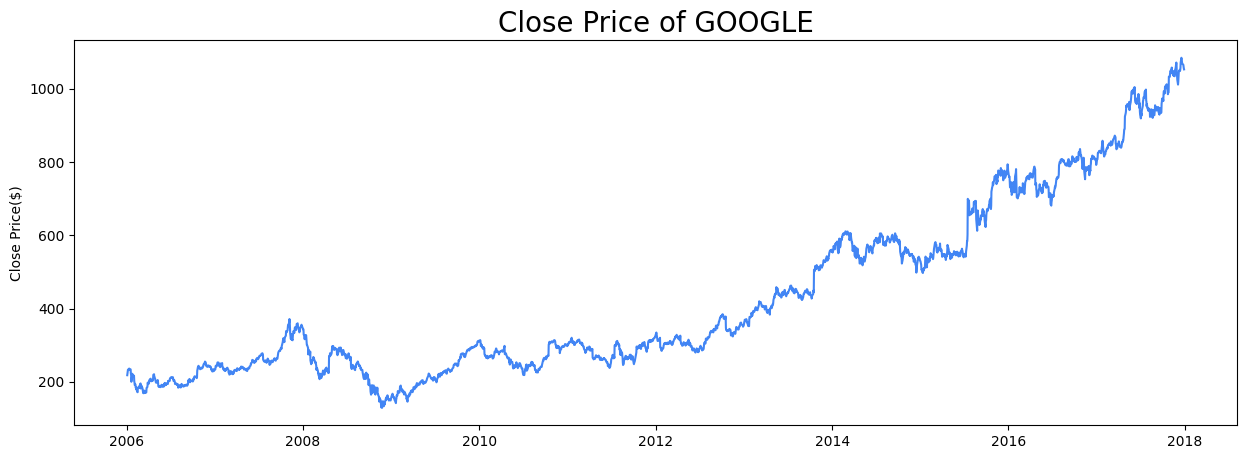

In [5]:
gblue = '#4285F4'
gred = '#DB4437'
gyellow = '#F4B400'
ggreen = '#0F9D58'

plt.figure(figsize=(15,5))
plt.plot(pd.to_datetime(df['Date']), df['Close'], color=gblue)
plt.ylabel('Close Price($)')
plt.title('Close Price of GOOGLE',
          fontsize=20)

Text(0.5, 1.0, 'Number of Shares Traded on GOOGLE')

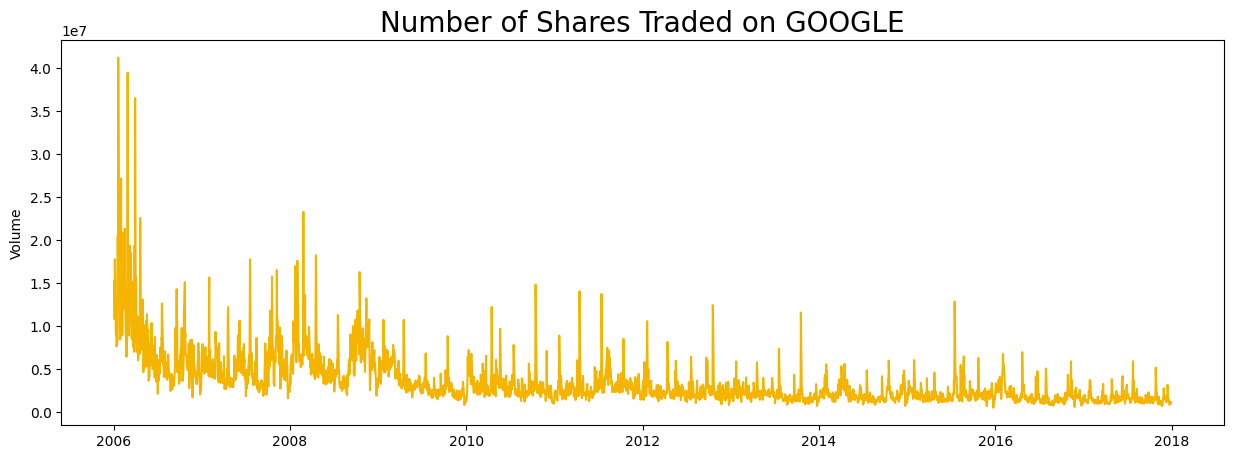

In [6]:
plt.figure(figsize=(15,5))
plt.plot(pd.to_datetime(df['Date']), df['Volume'], color=gyellow)
plt.ylabel('Volume')
plt.title('Number of Shares Traded on GOOGLE',
          fontsize=20)

In [7]:
# normalizing
dates = df['Date'].values
close = df['Close'].values
data_set = close.reshape(-1,1)

minmax_scaler = MinMaxScaler(feature_range=(0,1))
data_set_scaled = minmax_scaler.fit_transform(data_set)
data_set_scaled

array([[0.09305195],
       [0.09829122],
       [0.10143897],
       ...,
       [0.97397097],
       [0.96952648],
       [0.96685978]])

In [8]:
print("MAE Treshold: "+ str((data_set.max()-data_set.min())*10/100))

MAE Treshold: 95.624


In [9]:
def windowed_dataset(series, shuffle_buffer, window_size = 40, batch_size = 100):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [10]:
y_train, y_test = train_test_split(data_set_scaled, test_size=0.2, shuffle=False)

train_set = windowed_dataset(y_train, shuffle_buffer=1000)
test_set = windowed_dataset(y_test, shuffle_buffer=1000)

In [11]:
print(y_train.shape)
print(y_test.shape)

(2415, 1)
(604, 1)


In [12]:
model = Sequential()

model.add(LSTM(units=60, return_sequences=True, input_shape = [None, 1]))
model.add(Dropout(0.2))
model.add(LSTM(units=60))
model.add(Dropout(0.2)),
model.add(Dense(60, activation="relu")),
model.add(Dense(30, activation="relu")),
model.add(Dense(units=1))

model.compile(optimizer=SGD(lr=1.0000e-04, momentum=0.9),loss=tf.keras.losses.Huber(), metrics=["mae"])

In [13]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('mae')<10) and (logs.get('val_mae')<10):
      print('\nMAE is already <10%!')
      self.model.stop_training = True
callbacks = myCallback()

history = model.fit(train_set, epochs=100, validation_data=test_set, callbacks=callbacks)

Epoch 1/100
     23/Unknown - 16s 25ms/step - loss: 0.0125 - mae: 0.1297
MAE is already <10%!
24/24 [==============================] - 18s 110ms/step - loss: 0.0124 - mae: 0.1297 - val_loss: 0.1018 - val_mae: 0.4376


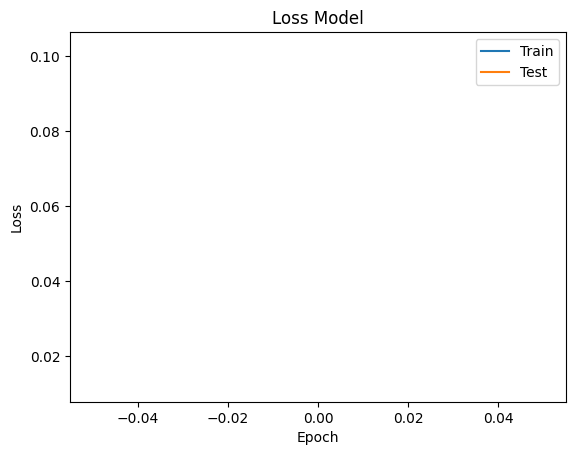

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

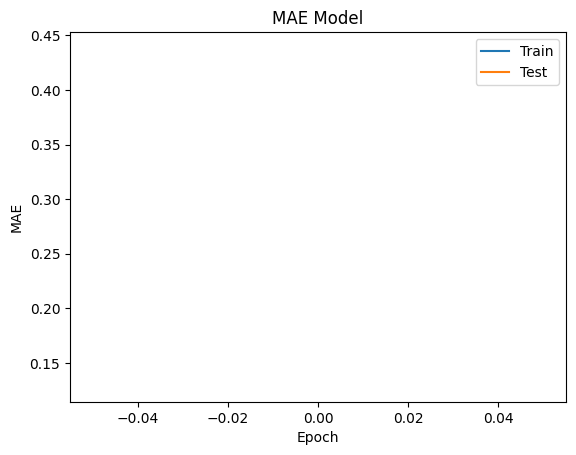

In [15]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE Model')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

In [16]:
history2 = model.fit(train_set, epochs=20, validation_data=test_set)

Epoch 1/20
24/24 [==============================] - 2s 70ms/step - loss: 0.0127 - mae: 0.1372 - val_loss: 0.1215 - val_mae: 0.4802
Epoch 2/20
24/24 [==============================] - 2s 73ms/step - loss: 0.0098 - mae: 0.1131 - val_loss: 0.1186 - val_mae: 0.4735
Epoch 3/20
24/24 [==============================] - 2s 76ms/step - loss: 0.0099 - mae: 0.1159 - val_loss: 0.1183 - val_mae: 0.4740
Epoch 4/20
24/24 [==============================] - 1s 33ms/step - loss: 0.0097 - mae: 0.1144 - val_loss: 0.1168 - val_mae: 0.4702
Epoch 5/20
24/24 [==============================] - 1s 29ms/step - loss: 0.0098 - mae: 0.1139 - val_loss: 0.1158 - val_mae: 0.4683
Epoch 6/20
24/24 [==============================] - 1s 41ms/step - loss: 0.0098 - mae: 0.1147 - val_loss: 0.1148 - val_mae: 0.4646
Epoch 7/20
24/24 [==============================] - 1s 32ms/step - loss: 0.0097 - mae: 0.1143 - val_loss: 0.1158 - val_mae: 0.4680
Epoch 8/20
24/24 [==============================] - 1s 33ms/step - loss: 0.0096 - m

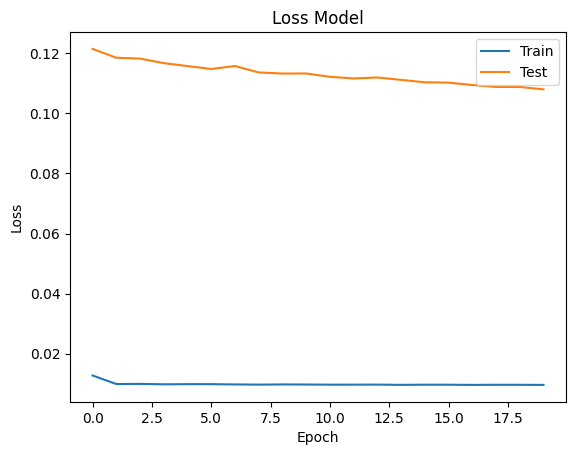

In [17]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

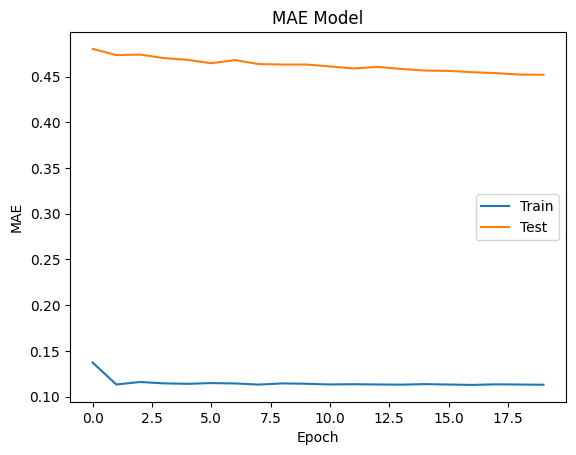

In [18]:
plt.plot(history2.history['mae'])
plt.plot(history2.history['val_mae'])
plt.title('MAE Model')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()